# Data carving with post-selection inference


## Background

In post-selection inference (PoSI), we want to run a classic linear regression on a subset of features that have been selected by some algorithm. The statistical quantity of interest is a one-dimensional term $\eta_j^T g=\beta^0_j$, which is the inner product of a row from the matrix $[(X^TX)^{-1}X^T]_{j:}$ and the signal component of the response for a model of additive error: $y=g(x)+e$, $e\sim N(0,\sigma^2 I_n)$, where $g$ is usually assumed to be linear. For example, if the Lasso is run for a fixed value of $\lambda$, then we could consider running a linear regression on only those coordinates which it selected non-zero coefficients for.

$$
M = \{j: \beta^{\text{lasso}}_\lambda \neq 0\} \subset \{1, \dots, p\}
$$

Recent research has shown that for the Lasso, and other algorithms (like marginal screening or forward stepwise regression), the selection event $M$ can be shown to be in bijection with a polyhedral constraints on $y$ which leads to a trunctated normal distribution.

$$
\hat\beta^{\text{PoSI}}_j = \eta^T_{M_j}y \sim \text{TN}(\beta_j^{M}, \sigma^2_M \|\eta_{M_j}\|^2_2, V^{-}(y), V^{+}(y))
$$

If this estimator is combined with another portion of data that was unused in the Lasso alogithm,

$$
\hat\beta^{\text{OLS}}_j = \eta^T_{M_j}y \sim N(\beta_j^{M}, \sigma^2_M \|\eta_{M_j}\|^2_2)
$$

Then the (weighted) sum of these two coefficients will follow an SNTN distribution, where $w_A$ and $w_B$ are the relative sample sizes which sum to one.

$$
\begin{align*}
\hat\beta^{\text{carve}}_j &= w_A \hat\beta^{\text{OLS}}_j + w_B \hat\beta^{\text{PoSI}}_j \\
&\sim SNTN(\beta_j^{M}, \sigma^2_M \|\eta^A_{M_j}\|^2_2, \beta_j^{M}, \sigma^2_M \|\eta^B_{M_j}\|^2_2, w_A, w_B)
\end{align*}
$$

## TLDR

The rest of this notebook will provide a tutorial on how to obtain inference with the SNTN distribution for data carving-PoSI for both the lasso and marginal screening. The Wisconsin Breast Cancer [dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)) will be used ($n=569$, $p=30$), and both the Lasso and marginal screening will be considered. A type-1 error rate of 5% is set with `alpha`.

The first code block shows to obtain inferene using the `lasso` and `marginal screen` wrappers. The sections after that will go into a deeper dive.

In [1]:
import sys
import os
sys.path.append('..')

# Load external packages
import numpy as np
import pandas as pd
import plotnine as pn
from scipy.stats import norm
from glmnet import ElasticNet
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
# Load SNTN utilities
from sntn.dists import nts, tnorm
from sntn.posi import lasso, marginal_screen

# For reproducability
seed = 1

# Checking numerical stability of solutions
kkt_tol = 5e-3

# Set up null-hypothesis testing
alpha = 0.05
null_beta = 0

# Load dataset
X, y = load_breast_cancer(return_X_y=True)
cn_X = load_breast_cancer().feature_names
n, p = X.shape

# Specify hyperparameters
pct_split = 0.50  # Percent to use for inference
lamb_fix = 1e-2  # lambda value for Lasso
k = 10  # Top-k correlated variables to select

# Run the PoSI-Lasso
wrapper_lasso = lasso(lamb_fix, y, X, frac_split=pct_split, seed=seed)
sigma2 = wrapper_lasso.ols_split.sig2hat
wrapper_lasso.run_inference(alpha, null_beta, sigma2)

# Run the PoSI-Marginal Screener
wrapper_margin = marginal_screen(k, y, X, frac_split=pct_split, seed=seed)
sigma2 = wrapper_margin.ols_split.sig2hat
wrapper_margin.run_inference(alpha, null_beta, sigma2)

In [2]:
# Combine results
res_lasso = pd.concat(objs=[wrapper_lasso.res_screen.assign(inf='Screening'), 
                            wrapper_lasso.res_split.assign(inf='Splitting'), 
                            wrapper_lasso.res_carve.assign(inf='Carving')], axis=0)
res_lasso.insert(0, 'mdl', 'Lasso')
res_margin = pd.concat(objs=[wrapper_margin.res_screen.assign(inf='Screening'), 
                             wrapper_margin.res_split.assign(inf='Splitting'), 
                             wrapper_margin.res_carve.assign(inf='Carving')], axis=0)
res_margin.insert(0, 'mdl', 'Marginal Screening')
res_posi = pd.concat(objs=[res_lasso, res_margin], axis=0).reset_index(drop=True)
res_posi = res_posi.assign(is_sig = lambda x: x['pval'] < alpha)

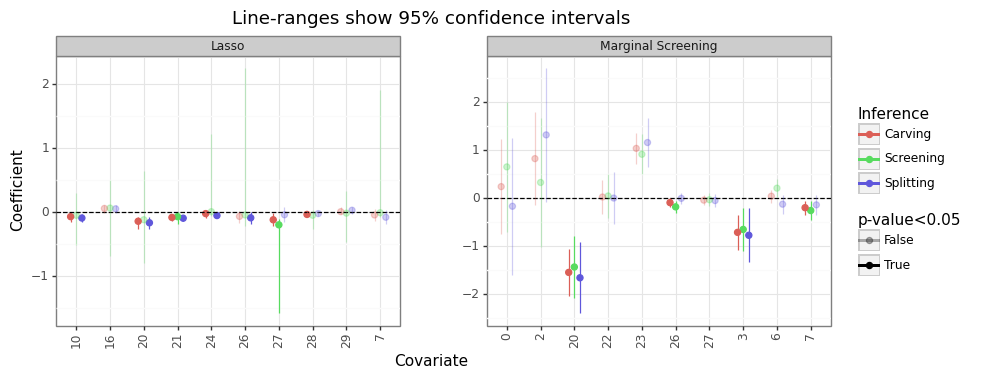

<ggplot: (431718377)>

In [3]:
# Plot
pn.options.figure_size = (10,3.5)
posd = pn.position_dodge(0.5)
gg_posi = (pn.ggplot(res_posi, pn.aes(x='cidx.astype(str)',y='bhat',color='inf',alpha='is_sig')) + 
            pn.theme_bw() + 
            pn.facet_wrap('~mdl',scales='free') + 
            pn.geom_point(size=2,position=posd) + 
            pn.geom_hline(yintercept=0,linetype='--') +
            pn.geom_linerange(pn.aes(ymin='lb.clip(lower=-100)',ymax='ub.clip(upper=100)'),position=posd) + 
            pn.ggtitle(f'Line-ranges show {100*(1-alpha):0.0f}% confidence intervals') + 
            pn.labs(x='Covariate',y='Coefficient') + 
            pn.scale_color_discrete(name='Inference') + 
            pn.scale_alpha_manual(name=f'p-value<{alpha}',values=[0.3,1]) + 
            pn.theme(axis_text_x=pn.element_text(angle=90),subplots_adjust={'wspace': 0.25}))
gg_posi

## Deep dive: Data-split

While the `posi` wrappers handle the data splitting under the hood, the rest of the notebook will show how to replicate these results from scratch. A 50/50% split will be used, such that half of the data will go towards fitting the Lasso and the other half will be used for inference.

Group A will refer to the inference set (unbiased) and group B refers to the screening set which will be used by the Lasso or marginal sceener.

In [4]:
X_B, X_A, y_B, y_A = train_test_split(X, y, test_size=pct_split, random_state=seed)
n_A, n_B = len(y_A), len(y_B)
w_A, w_B = n_A/n, n_B/n
# Normalize B (which will go into algorithms)
mu_A = X_A.mean(0)
mu_B = X_B.mean(0)
se_B = X_B.std(0,ddof=1)
Xtil_B = (X_B - mu_B) / se_B
# Put A on the same scale as B so the coefficients have the same intepretation, but de-mean so we don't need to worry about intercept
Xtil_A = (X_A - mu_A) / se_B

# De-mean y so we don't need to fit intercept
ytil_A = y_A - y_A.mean()
ytil_B = y_B - y_B.mean()

## Deep dive: Lasso-PoSI


Readers are encouraged to read [Lee et al. (2016)](https://projecteuclid.org/journals/annals-of-statistics/volume-44/issue-3/Exact-post-selection-inference-with-application-to-the-lasso/10.1214/15-AOS1371.full), hereafter **Lee16** for a derivation and proof and derivation of many of the terms that will be used.

In [5]:
# (i) Run the Lasso for some fixed value of lambda
lamb_path = np.array([lamb_fix*1.01, lamb_fix])  # ElasticNet wants >=2 values
mdl_lasso = ElasticNet(alpha=1, n_splits=0, standardize=False, lambda_path=lamb_path, tol=1e-20)
mdl_lasso.fit(Xtil_B, ytil_B)
bhat_lasso = mdl_lasso.coef_path_[:,1]
M_lasso = bhat_lasso != 0
cn_lasso = cn_X[M_lasso]
X_B_M = Xtil_B[:,M_lasso].copy()
# Check KKT conditions
kkt_lasso = np.abs(Xtil_B.T.dot(ytil_B - Xtil_B.dot(bhat_lasso)) / n_B)
err_kkt = np.max(np.abs(kkt_lasso[M_lasso] - lamb_fix))
assert err_kkt < kkt_tol, 'KKT conditions not met'
assert np.all(lamb_fix > kkt_lasso[~M_lasso]), 'KKT conditions not met'
n_sel = M_lasso.sum()
print(f'Lasso selected {n_sel} of {p} features for lambda={lamb_fix} (KKT-err={err_kkt:0.5f})')

# (ii) Run OLS on the screening portion
igram_B_M = np.linalg.inv(np.dot(X_B_M.T, X_B_M))
eta_B_M = np.dot(X_B_M, igram_B_M)
bhat_B = np.dot(eta_B_M.T, ytil_B)

# (iii) Run inference on the classical held-out portion
X_A_M = Xtil_A[:,M_lasso].copy()
igram_A_M = np.linalg.inv(np.dot(X_A_M.T, X_A_M))
eta_A_M = np.dot(X_A_M, igram_A_M)
bhat_A = np.dot(eta_A_M.T, ytil_A)

# (iv) Use held-out portion to estimate variance of the error
resid_A = ytil_A - np.dot(X_A_M, bhat_A)
sigma2_A = np.sum(resid_A**2) / (n_A - (n_sel+1))
tau21 = sigma2_A * np.sum(eta_A_M**2,0)

Lasso selected 10 of 30 features for lambda=0.01 (KKT-err=0.00000)


Following Lee's paper, we'll follow equations (4.8) to (5.6), using only A1/b1 because we are only considering partial inference.

In [6]:
# (v) Calculate the polyhedral constraints
sign_M = np.diag(np.sign(bhat_lasso[M_lasso]).astype(int))
A = -np.dot(sign_M, eta_B_M.T)
# Note, that lambda is multiplied by n_B since the solution below solves for the non-normalized version
b = -n_B * lamb_fix * np.dot(sign_M, np.dot(igram_B_M, sign_M.diagonal()))
# Check for constraint error
assert  np.all(A.dot(ytil_B) <= b), 'Polyhedral constraint not met!'

# (vi) Calculate the truncated normal values (4.8 to 5.6 for Lee's paper, using only A1/A2)
tau22 = sigma2_A * np.sum(eta_B_M**2,0)
D = np.sqrt(tau22 / sigma2_A)
V = eta_B_M / D
R = np.squeeze(np.dstack([np.dot(np.identity(n_B) - np.outer(V[:,j],V[:,j]),ytil_B)  for j in range(n_sel)]))
AV = np.dot(A, V)
AR = A.dot(R)
nu = (b.reshape([n_sel,1]) - AR) / AV
idx_neg = AV < 0
idx_pos = AV > 0
a = np.max(np.where(idx_neg, nu, -np.inf),0) * D
b = np.min(np.where(idx_pos, nu, +np.inf),0) * D
assert np.all(b > a), 'expected pos to be larger than neg'

We can now set up all of the specific distributions.

In [7]:
# Signs can be used to determine direction of hypothesis test
is_sign_neg = np.sign(bhat_lasso[M_lasso])==-1

# (i) PoSI with the Lasso
dist_tnorm = tnorm(null_beta, tau22, a, b)
pval_tnorm = dist_tnorm.cdf(bhat_B)
pval_tnorm = np.where(is_sign_neg, pval_tnorm, 1-pval_tnorm)
res_tnorm = pd.DataFrame({'mdl':'Screening','cn':cn_lasso,'bhat':bhat_B, 'pval':pval_tnorm})
res_tnorm = pd.concat(objs=[res_tnorm, pd.DataFrame(dist_tnorm.conf_int(bhat_B, alpha),columns=['lb','ub'])],axis=1)

# (ii) OLS on inference set
dist_norm = norm(loc=null_beta, scale=np.sqrt(tau21))
pval_norm = dist_norm.cdf(bhat_A)
pval_norm = np.where(is_sign_neg, pval_norm, 1-pval_norm)
res_norm = pd.DataFrame({'mdl':'Splitting','cn':cn_lasso, 'bhat':bhat_A, 'pval':pval_norm})
res_norm = pd.concat(objs=[res_norm, pd.DataFrame(np.vstack(norm(bhat_A, np.sqrt(tau21)).interval(1-alpha)).T,columns=['lb','ub'])],axis=1)


# (iii) Data carving on both
bhat_wAB = w_A*bhat_A + w_B*bhat_B
dist_sntn = nts(null_beta, tau21, null_beta, tau22, a, b, w_A, w_B, fix_mu=True)
pval_sntn = dist_sntn.cdf(bhat_wAB)
pval_sntn = np.where(is_sign_neg, pval_sntn, 1-pval_sntn)
res_sntn = pd.DataFrame({'mdl':'Carving','cn':cn_lasso,'bhat':bhat_wAB, 'pval':pval_sntn})
res_sntn = pd.concat(objs=[res_sntn, pd.DataFrame(np.squeeze(dist_sntn.conf_int(bhat_wAB, alpha)),columns=['lb','ub'])],axis=1)

This should align to the results we find the wrapper

In [8]:
print(np.max(np.abs(res_sntn['pval'] - res_lasso.loc[res_lasso['inf'] == 'Carving','pval'])))

1.2656542480726785e-14


### Comparing to `R`

As the [wisconsin_replicate.R](wisconsin_replicate.R) file shows, the python wrapper can get close to the same results (where the confidence intervals differ slightly due to the different root finding routines in effect).

<img src="selectiveInference_wisconsin.png" width="50%">

In [9]:
ytil = y - y.mean()
xtil = (X - X.mean(0)) / X.std(0, ddof=0)
inf2R = lasso(0.1, y, X, frac_split=0)
inf2R.run_inference(alpha, null_beta, 1.0, run_split=False, run_carve=False)
inf2R.res_screen.round(3)

,cidx,bhat,pval,lb,ub
0,7,-0.067,0.841,-0.243,2.774
1,20,-0.156,0.034,-1.049,0.020
2,21,-0.084,0.606,-0.155,0.637
3,27,-0.170,0.041,-2.127,0.051


## (3) Marginal screening

Following the same recipe for the Lasso, this time we will follow [Lee & Taylor (2014)](https://arxiv.org/abs/1402.5596), hereafter **Lee14** to break down step-by-step what is happening under the hood for the posi.marginal_screen wrapper.

In [10]:
# (i) Run marginal screening and find the top-k features
k = 10
Xty = Xtil_B.T.dot(ytil_B)
aXty = np.abs(Xty)
cidx_ord = pd.Series(aXty).sort_values().index.values
cidx_k = cidx_ord[-k:]
S_margin = np.sign(Xty[cidx_k])
assert np.all(np.sign(Xty) == np.sign([np.corrcoef(Xtil_B[:,j],ytil_B)[0,1] for j in range(p)])), 'Inner product should align with signs of Pearson correlation'
M_margin = np.isin(np.arange(p), cidx_k)
cn_margin = cn_X[M_margin]
X_B_M = Xtil_B[:,M_margin].copy()
# Check KKT
assert np.all(np.atleast_2d(aXty[M_margin]).T > aXty[~M_margin]), 'KKT for marginal screening not met'

# (ii) Run OLS on the screening portion
igram_B_M = np.linalg.inv(np.dot(X_B_M.T, X_B_M))
eta_B_M = np.dot(X_B_M, igram_B_M)
bhat_B = np.dot(eta_B_M.T, ytil_B)

# (iii) Run inference on the classical held-out portion
X_A_M = Xtil_A[:,M_margin].copy()
igram_A_M = np.linalg.inv(np.dot(X_A_M.T, X_A_M))
eta_A_M = np.dot(X_A_M, igram_A_M)
bhat_A = np.dot(eta_A_M.T, ytil_A)

# (iv) Use held-out portion to estimate variance of the error
resid_A = ytil_A - np.dot(X_A_M, bhat_A)
sigma2_A = np.sum(resid_A**2) / (n_A - (k+1))
tau21 = sigma2_A * np.sum(eta_A_M**2,0)

# (v) Calculate the polyhedral constraints
partial = np.identity(p)
partial = partial[~M_margin]
partial = np.vstack([partial, -partial])

Now we ready to calculate the the polyhedral constraints (see equations (5)-(8) from Lee14).

In [11]:
# Create an array with all zeros
A = np.zeros(partial.shape + (k,))
# Set specified column indices to opposite sign of the coeficient
for i, idx in enumerate(cidx_k):
    A[:, idx, i] = -S_margin[i]
A = np.vstack([A[...,j] for j in range(k)])
A += np.tile(partial,[k,1])
A = A.dot(Xtil_B.T)
# Check for constraint error
Ay = A.dot(ytil_B.reshape([n_B,1]))
assert  np.all(Ay <= 0), 'Polyhedral constraint not met for marginal screening!'

# (vi) Calculate the truncated normal values 
tau22 = sigma2_A * np.sum(eta_B_M**2,0)
# See equation (6) - sigma2 will cancel out with tau22 when normalized
alph_num = sigma2_A * np.dot(A, eta_B_M)
alph = alph_num / tau22
ratio = -Ay/alph + np.atleast_2d(bhat_B)
idx_neg = alph < 0
idx_pos = alph > 0
a = np.max(np.where(alph < 0, ratio, -np.inf), axis=0)
b = np.min(np.where(alph > 0, ratio, +np.inf), axis=0)
assert np.all(b > a), 'expected pos to be larger than neg'

As before, we can use the custom distribution classes to get the inference under the null hypothesis.

In [12]:
is_sign_neg = S_margin==-1

# (i) PoSI with the Lasso
dist_tnorm = tnorm(null_beta, tau22, a, b)
pval_tnorm = dist_tnorm.cdf(bhat_B)
pval_tnorm = np.where(is_sign_neg, pval_tnorm, 1-pval_tnorm)
res_tnorm = pd.DataFrame({'mdl':'Screening','cn':cn_margin,'bhat':bhat_B, 'pval':pval_tnorm})
res_tnorm = pd.concat(objs=[res_tnorm, pd.DataFrame(dist_tnorm.conf_int(bhat_B, alpha),columns=['lb','ub'])],axis=1)

# (ii) OLS on inference set
dist_norm = norm(loc=null_beta, scale=np.sqrt(tau21))
pval_norm = dist_norm.cdf(bhat_A)
pval_norm = np.where(is_sign_neg, pval_norm, 1-pval_norm)
res_norm = pd.DataFrame({'mdl':'Splitting','cn':cn_margin, 'bhat':bhat_A, 'pval':pval_norm})
res_norm = pd.concat(objs=[res_norm, pd.DataFrame(np.vstack(norm(bhat_A, np.sqrt(tau21)).interval(1-alpha)).T,columns=['lb','ub'])],axis=1)

# (iii) Data carving on both
bhat_wAB = w_A*bhat_A + w_B*bhat_B
dist_sntn = nts(null_beta, tau21, null_beta, tau22, a, b, w_A, w_B, fix_mu=True)
pval_sntn = dist_sntn.cdf(bhat_wAB)
pval_sntn = np.where(is_sign_neg, pval_sntn, 1-pval_sntn)
res_sntn = pd.DataFrame({'mdl':'Carving','cn':cn_margin,'bhat':bhat_wAB, 'pval':pval_sntn})
res_sntn = pd.concat(objs=[res_sntn, pd.DataFrame(np.squeeze(dist_sntn.conf_int(bhat_wAB, alpha)),columns=['lb','ub'])],axis=1)

This should give us the same inference as the wrapper

In [13]:
print(np.max(np.abs(res_sntn.sort_values('bhat')['pval'].values - res_margin.loc[res_margin['inf'] == 'Carving'].sort_values('bhat')['pval'].values)))

4.2732484217822275e-13
